<a id='lr_scheduler'></a>
## [Learning Rate Scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

The learning rate denoted usually by $\alpha$ is a hyperparameter that controls the pace at which the optimizer updates the network's parameters.
The learning rate may be the most important hyperparameter to set when configuring the training.
Choosing this hyperparameter is challenging as a value too small may result in slow learning and a value too large may cause unstable or sub-optimal learning.

PyTorch provides a great set of tools to create a scheduled learning rate. This means the learning rate can be changed during the training.
In this notebook, I introduce these tools.

By reading this notebook, you will learn:
- different available learning rate scheduler in PyTorch,
- how to use one learning rate scheduler,
- how to use multiple learning rate scheduler,
- how to create a learning rate scheduler with custom function.


This notebook will cover the following topics:
- [Learning Rate Scheduler](#lr_scheduler)
- [1. LambdaLR](#LambdaLR)
- [2. MultiplicativeLR](#MultiplicativeLR)
- [3. StepLR](#StepLR)
- [4. MultiStepLR](#MultiStepLR)
- [5. ConstantLR](#ConstantLR)
- [6. LinearLR](#LinearLR)
- [7. ExponentialLR](#ExponentialLR)
- [8. PolynomialLR](#PolynomialLR)
- [9. CosineAnnealingLR](#CosineAnnealingLR)
- [10. CosineAnnealingWarmRestarts](#CosineAnnealingWarmRestarts)
- [11. CyclicLR](#CyclicLR)
- [12. OneCycleLR](#OneCycleLR)
- [13. ChainedScheduler](#ChainedScheduler)
- [14. SequentialLR](#SequentialLR)
- [15. ReduceLROnPlateau](#ReduceLROnPlateau)
- [Conclusions](#Conclusions)
- [References](#references)


 

In [152]:
import matplotlib.pyplot as plt
import torch

def plot(epochs, lr, title, labels=None, linestyle=None):
    if len(lr) != epochs:
        n = len(lr)
    else:
        n = 1
        labels = [None]
        linestyle = ["-"]
        # color = "k"
        lr = [lr]
    
    fig, ax = plt.subplots(1,1,figsize=(4,3),
                           facecolor='#181D31') 
    ax.set_facecolor('#181D31')
    for i in range(n):
        ax.plot(range(epochs), lr[i], "o", linestyle=linestyle[i], 
                color="#FED049",
                markersize=3, label=labels[i])
    ax.set_title(title, color="w")
    ax.set_xlabel("Epoch", color="w")
    ax.set_ylabel(r"$\alpha$", color="w")
    ax.grid()
    ax.tick_params(axis='x', colors='w')
    ax.tick_params(axis='y', colors='w')
    if labels[0] is not None:
        leg = plt.legend()
        for text in leg.get_texts():
            text.set_color("w")
        frame = leg.get_frame()
        frame.set_facecolor('#181D31')
        frame.set_edgecolor("gray")
model = torch.nn.Conv2d(3, 64, kernel_size=3)


epochs = 20
lr0 = 0.1


<a id="LambdaLR"></a>
## 1. [LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html)

[LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR) sets the learning rate of each parameter group to the initial lr times a given function.

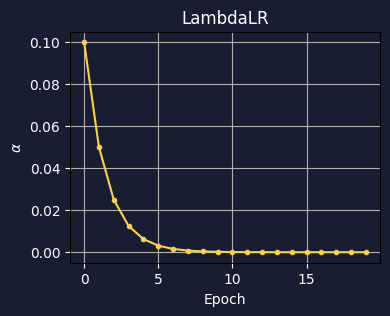

In [153]:
from torch.optim.lr_scheduler import LambdaLR

lambda1 = lambda epoch: 0.5 ** epoch

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = LambdaLR(optimizer=optimizer, lr_lambda=lambda1)

lr = []
for epoch in range(epochs):
    optimizer.step()        
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
plot(epochs, lr, title="LambdaLR")



By calling the scheduler, the value of learning rate in the optimizer (`lr`) becomes zero and the optimizer gets another key as `initial_lr` which keeps the initial value of the learning rate. 
So, we have 
```Python
optimizer.param_groups[0]['lr'] = 0.0 
optimizer.param_groups[0]['initial_lr'] = 0.1
```
assuming we first set the learning rate of the optimizer as 0.1
```Python
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
```
By scheduling, we have
```
lr = initial_lr * f(epoch)
```

<a id="MultiplicativeLR"></a>
## 2. [MultiplicativeLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiplicativeLR.html)

This method, multiplies the learning rate of each parameter groupe by the factor given in a specified function.
```
lr = lr * f(epoch)
```
This is equivalent of 
```Python
a = 0.1
f = lambda epoch: 0.5 ** epoch

for i in range(10):
    a = a*f(i)
    print(i, a)
```

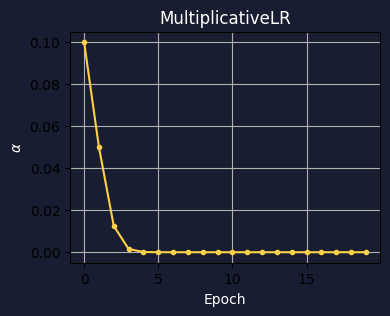

In [134]:
from torch.optim.lr_scheduler import MultiplicativeLR

lambda1 = lambda epoch: 0.5 ** epoch

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = MultiplicativeLR(optimizer=optimizer, lr_lambda=lambda1)

lr = []
for epoch in range(epochs):
    optimizer.step()        
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plot(epochs, lr, title="MultiplicativeLR")




<a id='StepLR'></a>
## 3. [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)

Decays the learning rate of each parameter group by gamma every `step_size` epochs.
This is equivalent of 

```Python
gamma: float = <defined by user>
lr: float = <defined by user>
step: int = <defined by user>

for epoch in range(1, epochs+1):
    ...
    if epoch % step == 0:
        lr *= gamma
```

It means

$
    \alpha = 
\begin{cases}
    \gamma \times \alpha ,& \text{if epoch \% step =0}\\
    \alpha,              & \text{otherwise}
\end{cases}
$



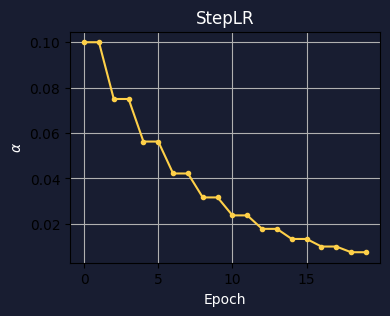

In [135]:
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = StepLR(optimizer=optimizer, step_size=2, gamma=0.75)

lr = []
for epoch in range(epochs):
    optimizer.step()        
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plot(epochs, lr, title="StepLR")


<a id='MultiStepLR'></a>
## 4. [MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html)

Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.
This is equivalent of 

```Python
gamma: float = <defined by user>
lr: float = <defined by user>
milestones: [int] = <defined by user>

for epoch in range(epochs):
    ...
    if epoch in milestones:
        lr *= gamma
```

It means

$
    \alpha = 
\begin{cases}
    \gamma \times \alpha ,& \text{if epoch in [milestones]}\\
    \alpha,              & \text{otherwise}
\end{cases}
$



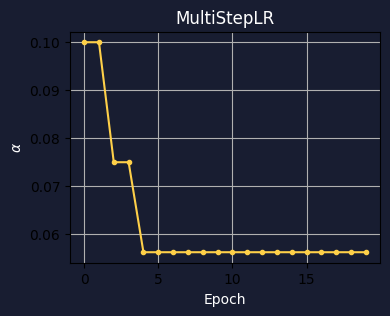

In [136]:
from torch.optim.lr_scheduler import MultiStepLR

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = MultiStepLR(optimizer=optimizer, milestones=[2, 4], gamma=0.75)

lr = []
for epoch in range(epochs):
    optimizer.step()        
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plot(epochs, lr, title="MultiStepLR")

<a id="ConstantLR"></a>
## 5. [ConstantLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ConstantLR.html)

Decays the learning rate of each parameter group by a small constant factor until the number of epoch reaches a predefined milestone: `total_iters`.



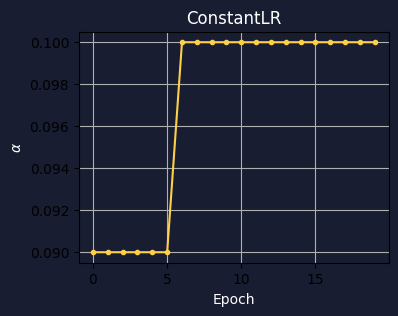

In [137]:
from torch.optim.lr_scheduler import ConstantLR

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = ConstantLR(optimizer=optimizer, factor=0.9, total_iters=6)

lr = []
for epoch in range(epochs):
    optimizer.step()        
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plot(epochs, lr, title="ConstantLR")

<a id="LinearLR"></a>
## 6. [LinearLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LinearLR.html)

Decays the learning rate of each parameter group by linearly changing small multiplicative factor until the number of epoch reaches a pre-defined milestone: `total_iters`.

If `start_factor` > `end_factor`, learning rate will decrease during the iteration and it will increase if this condition is reversed.

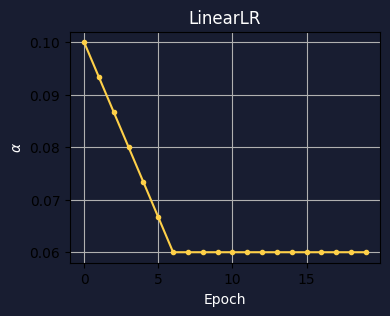

In [138]:
from torch.optim.lr_scheduler import LinearLR

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = LinearLR(optimizer=optimizer, start_factor=1.0, end_factor=0.6,
                     total_iters=6)

lr = []
for epoch in range(epochs):
    optimizer.step()        
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plot(epochs, lr, title="LinearLR")

<a id="ExponentialLR"></a>
## 7. [ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)

Decays the learning rate of each parameter group by `gamma` every epoch.
This is equivalent of 

```Python
gamma: float = <defined by user>
lr: float = <defined by user>

f = lambda lr: lr * gamma
for i in range(10):
    lr = f(lr)
```

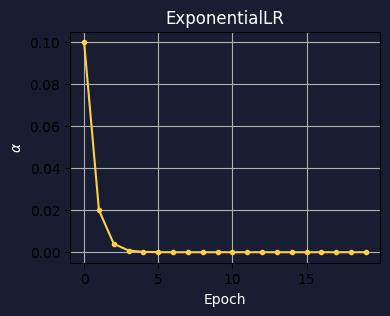

In [139]:
from torch.optim.lr_scheduler import ExponentialLR

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = ExponentialLR(optimizer=optimizer, gamma=0.2)

lr = []
for epoch in range(epochs):
    optimizer.step()    
    lr_epoch = optimizer.param_groups[0]["lr"]
    
    lr.append(lr_epoch)
    scheduler.step()
    # print(lr_epoch)

plot(epochs, lr, title="ExponentialLR")

<a id="PolynomialLR"></a>
## 8. [PolynomialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.PolynomialLR.html)

Decays the learning rate of each parameter group using a polynomial function in the given `total_iters`.

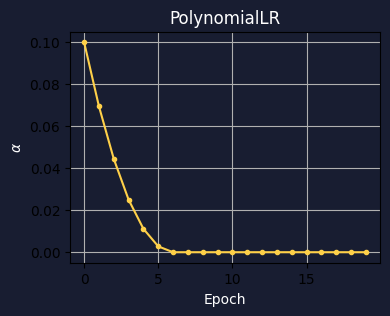

In [140]:
from torch.optim.lr_scheduler import PolynomialLR

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = PolynomialLR(optimizer=optimizer, power=2, total_iters=6)

lr = []
for epoch in range(epochs):
    optimizer.step()    
    lr_epoch = optimizer.param_groups[0]["lr"]
    
    lr.append(lr_epoch)
    scheduler.step()
    # print(lr_epoch)

plot(epochs, lr, title="PolynomialLR")

<a id="CosineAnnealingLR"></a>
## 9. [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html)

Set the learning rate of each parameter group using a cosine annealing schedule.



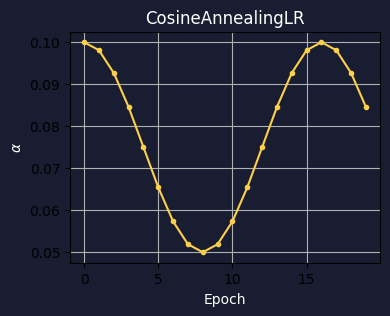

In [141]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = CosineAnnealingLR(optimizer,
                              T_max = 8, # Number of epochs in half of the priod 
                             eta_min = .05 # Minimum learning rate
                             ) 
lr = []
for epoch in range(epochs):
    optimizer.step()    
    lr_epoch = optimizer.param_groups[0]["lr"]
    
    lr.append(lr_epoch)
    scheduler.step()
    # print(lr_epoch)

plot(epochs, lr, title="CosineAnnealingLR")

<a id="CosineAnnealingWarmRestarts"></a>
## 10. [CosineAnnealingWarmRestarts](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html)

This scheduler acts like [CosineAnnealingLR](#CosineAnnealingLR), but it restarts the learning rate with its initial value when the epoch value reaches `T_0`.
This is called "warm restart".


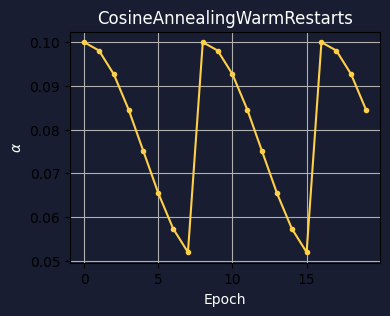

In [142]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

optimizer = torch.optim.Adam(model.parameters(), lr=lr0)

scheduler = CosineAnnealingWarmRestarts(optimizer,
                              T_0 = 8, # Number of epochs in half of the priod 
                             eta_min = .05 # Minimum learning rate
                             ) 
lr = []
for epoch in range(epochs):
    optimizer.step()    
    lr_epoch = optimizer.param_groups[0]["lr"]
    
    lr.append(lr_epoch)
    scheduler.step()
    # print(lr_epoch)

plot(epochs, lr, title="CosineAnnealingWarmRestarts")

<a id="CyclicLR"></a>
## 11. [CyclicLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html)

This scheduler adjusts the learning rate using cyclical learning rate policy (CLR).
The policy cycles the learning rate between two boundaries with a constant frequency.



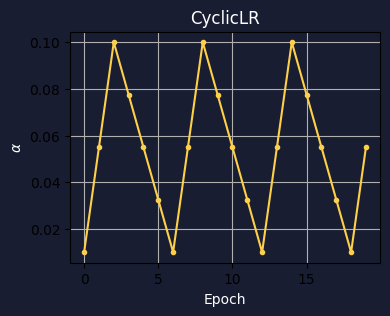

In [143]:
from torch.optim.lr_scheduler import CyclicLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

scheduler = CyclicLR(optimizer,
                     base_lr=lr0/10,     # Initial learning rate
                     max_lr=lr0,    # Upper learning rate boundaries in the cycle
                     step_size_up=2,  # Number of training iterations in the increasing half of a cycle
                     step_size_down=4, # Number of training iterations in the decreasing half of a cycle
                     mode="triangular"  
                     )

lr = []
for epoch in range(epochs):
    optimizer.step()    
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plot(epochs, lr, title="CyclicLR")

With `mode=triangular2` we have

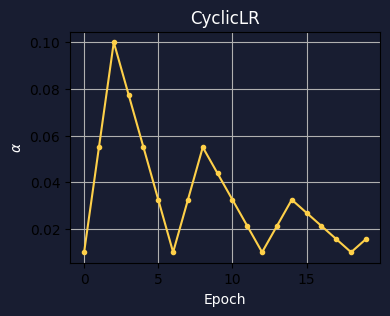

In [144]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

scheduler = CyclicLR(optimizer,
                     base_lr=lr0/10,     # Initial learning rate
                     max_lr=lr0,    # Upper learning rate boundaries in the cycle
                     step_size_up=2,  # Number of training iterations in the increasing half of a cycle
                     step_size_down=4, # Number of training iterations in the decreasing half of a cycle
                     mode="triangular2" 
                     )

lr = []
for epoch in range(epochs):
    optimizer.step()    
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plot(epochs, lr, title="CyclicLR")

<a id="OneCycleLR"></a>
## 12. [OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html)

This scheduler adjusts the learning rate using cyclical learning rate policy (CLR).
The policy cycles the learning rate between two boundaries with a constant frequency



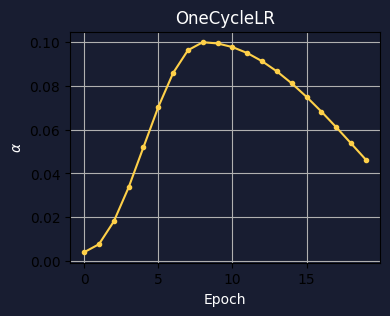

In [145]:
from torch.optim.lr_scheduler import OneCycleLR

optimizer = torch.optim.SGD(model.parameters(), lr=lr0, momentum=0.9)

scheduler = OneCycleLR(optimizer,
                     max_lr=lr0,    # Upper learning rate boundaries in the cycle
                     total_steps=int(1.5*epochs), # The total number of steps in the cycle. 
                     epochs=epochs)  # Number of training iterations in the increasing half of a cycle
                    

lr = []
for epoch in range(epochs):
    optimizer.step()    
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    
plot(epochs, lr, title="OneCycleLR")


<a id="ChainedScheduler"></a>
## 13. [ChainedScheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ChainedScheduler.html)

Chains list of learning rate schedulers. It takes a list of chainable learning rate schedulers and performs consecutive `step()` functions belonging to them by just one call.


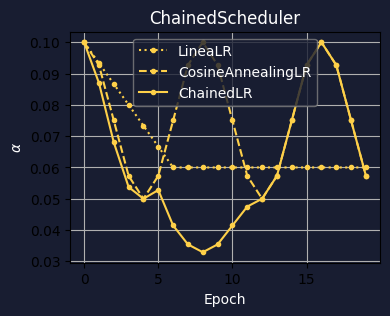

In [146]:
from torch.optim.lr_scheduler import ChainedScheduler

optimizer_linealr = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer_cosinelr = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler_linealr = CosineAnnealingLR(optimizer_cosinelr, T_max = 4, eta_min = .05) 
scheduler_cosinelr = LinearLR(optimizer_linealr, start_factor=1.0, end_factor=0.6, total_iters=6)

scheduler1 = LinearLR(optimizer=optimizer, start_factor=1.0, end_factor=0.6, total_iters=6)
scheduler2 = CosineAnnealingLR(optimizer, T_max = 4, eta_min = .05) 
scheduler = ChainedScheduler([scheduler1, scheduler2])


lr = []
lr_lieanr = []
lr_cosine = []

for epoch in range(epochs):
    optimizer_linealr.step()
    optimizer_cosinelr.step()
    optimizer.step()    
    
    lr_lieanr.append(optimizer_linealr.param_groups[0]["lr"])
    lr_cosine.append(optimizer_cosinelr.param_groups[0]["lr"])
    lr.append(optimizer.param_groups[0]["lr"])
    
    scheduler_linealr.step() 
    scheduler_cosinelr.step()
    scheduler.step()
    
plot(epochs, [lr_lieanr, lr_cosine, lr], title="ChainedScheduler",
     labels=["LineaLR", "CosineAnnealingLR","ChainedLR"],
     linestyle=[":", "--", "-"])


<a id="SequentialLR"></a>
## 14. [SequentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.SequentialLR.html)

Receives the list of schedulers that is expected to be called sequentially during optimization process and milestone points that provides exact intervals to reflect which scheduler is supposed to be called at a given epoch.


/Users/amir/repos/venv/AI/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


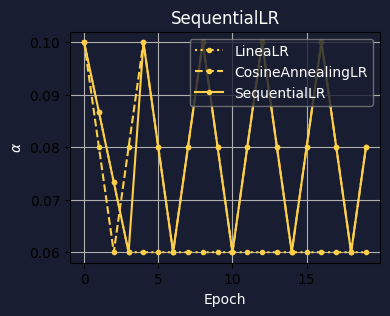

In [147]:
from torch.optim.lr_scheduler import SequentialLR

optimizer_linealr = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer_cosinelr = torch.optim.Adam(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler_linealr = CosineAnnealingLR(optimizer_cosinelr, T_max = 2, eta_min = .06) 
scheduler_cosinelr = LinearLR(optimizer_linealr, start_factor=1.0, end_factor=0.6, total_iters=3)

scheduler1 = LinearLR(optimizer=optimizer, start_factor=1.0, end_factor=0.6, total_iters=3)
scheduler2 = CosineAnnealingLR(optimizer, T_max = 2, eta_min = .06) 
scheduler = SequentialLR(optimizer, [scheduler1, scheduler2], milestones=[4])


lr = []
lr_lieanr = []
lr_cosine = []

for epoch in range(epochs):
    optimizer_linealr.step()
    optimizer_cosinelr.step()
    optimizer.step()    
    
    lr_lieanr.append(optimizer_linealr.param_groups[0]["lr"])
    lr_cosine.append(optimizer_cosinelr.param_groups[0]["lr"])
    lr.append(optimizer.param_groups[0]["lr"])
    
    scheduler_linealr.step() 
    scheduler_cosinelr.step()
    scheduler.step()
    
plot(epochs, [lr_lieanr, lr_cosine, lr], title="SequentialLR",
     labels=["LineaLR", "CosineAnnealingLR","SequentialLR"],
     linestyle=[":", "--", "-"])

<a id="ReduceLROnPlateau"></a>
## 15. [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html)

Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This scheduler reads a metrics quantity and if no improvement is seen for a `patience` number of epochs, the learning rate is reduced.

Considering a loss array as 
```Python
loss = [2.0, 1.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.25]
```
this scheduler can be used to reduce the learning rate when loss stops reducing, `mode = "min"`. 



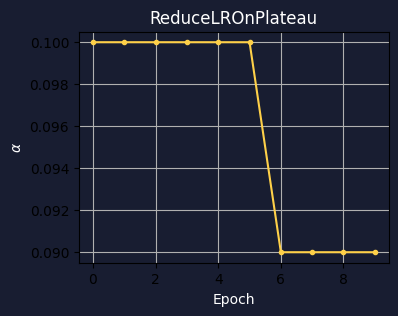

In [148]:
epochs = 10
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.9, patience=2)

loss = [2.0, 1.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.25]

lr = []

for epoch in range(epochs):
    optimizer.step()    
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step(loss[epoch])
    
plot(epochs, lr, title="ReduceLROnPlateau")

Or considering an accuracy array as 
```Python
accuracy = [2.0, 2.5, 3.0, 3.0, 3.0, 3.0, 3.5, 3.5, 3.5, 4.25]
```
this scheduler can be used to reduce the learning rate when the accuracy stops increasing, `mode = "max"`. 

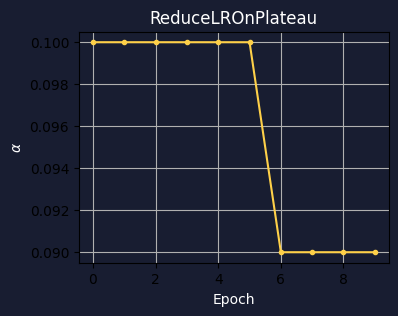

In [149]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.9, patience=2)

accuracy = [2.0, 2.5, 3.0, 3.0, 3.0, 3.0, 3.5, 3.5, 3.5, 4.25]

lr = []

for epoch in range(epochs):
    optimizer.step()    
    lr.append(optimizer.param_groups[0]["lr"])
    scheduler.step(accuracy[epoch])
    
plot(epochs, lr, title="ReduceLROnPlateau")

<a id="Conclusions"></a>
## Conclusions

In this notebook, we studied the available learning rate schedulers in PyTorch.
[LambdaLR](#LambdaLR) and[MultiplicativeLR](#MultiplicativeLR) can be used to create custom learning rate schedulers where the other methods use a specific function to adjust the learning rate.

Well, which method should we use? This is not a simple question and needs some experiments on you specific problem.
Personally, I usually try to use [ReduceLROnPlateau](#ReduceLROnPlateau) in my projects to adjust the learning rate based based on the accuracy of validation set. 
I hope you enjoyed this notebook and it helped you visualize and understand better diffefrent method.



<a id="references"></a>
## References

1. [torch.optim](#https://pytorch.org/docs/stable/optim.html)
1. [Understand the Impact of Learning Rate on Neural Network Performance](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)
